In [1]:
# Authors: Samantha Tetef and Vikram Kashyap
# Date: Winter 2020-2021 to Summer 2021

In [2]:
import warnings
warnings.filterwarnings("ignore")

import utils
from utils import *
from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *


import os
import copy
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.colors import to_hex
from matplotlib.colors import ListedColormap
import mplcursors

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster import hierarchy

from itertools import compress

from pathlib import Path

import webbrowser

warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

In [4]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

In [5]:
X_data_classed = [c for c in X_data if c['Class']!='None']

CIDs = np.array([c['CID'] for c in X_data])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

compoundmap = {compound['CID']:compound for compound in X_data}

typecodemap = {compound['CID']:compound['Type'] for compound in X_data}
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data}

classnames = list(CLASSCODES.keys())[:-1]
typecodes = np.unique(list(TYPECODES.values()))[:-1]

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

In [6]:
good, bad = 0, 0
diff = []
for compound in X_data:
    x, y = compound['XANES_Transitions']
    whiteline_E = x[np.argmax(y[:-5])]
    max_E = whiteline_E + 15
    num_above_threshold = np.sum(x > max_E)
    
    last_trans = x[0]
    diff.append(max_E - last_trans)
    
    if num_above_threshold > 0:
        good += 1
    else:
        bad += 1
diff = np.array(diff)
print(f'{good} good vs {bad} bad')
print(np.average(diff), ' +/- ', np.std(diff))

162 good vs 608 bad
2.240075454545448  +/-  8.260954096383378


In [7]:
len(CIDs)

770

# Visualization of Classification Distributions

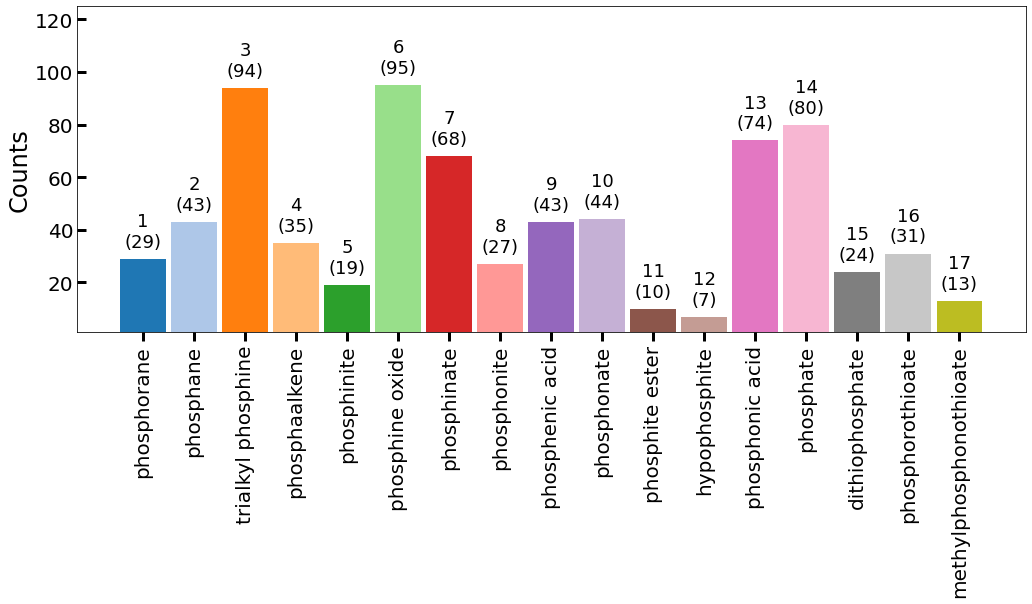

In [8]:
bins = [len([c for c in X_data if c['Class']==classname]) for classname in classnames]
hist(bins, [c.replace('_', ' ') for c in classnames], verbose=True)

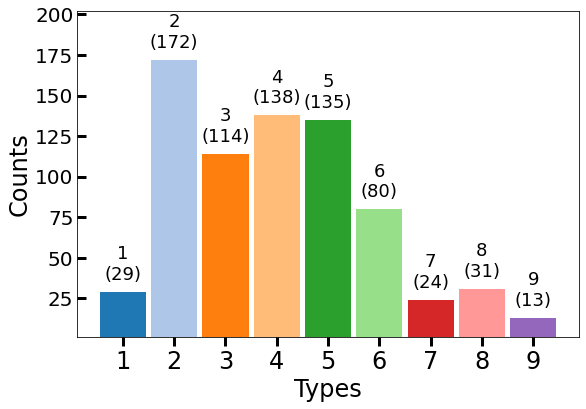

In [9]:
bins = [len([c for c in X_data if c['Type']==typecode]) for typecode in typecodes]
hist(bins, typecodes, verbose=True, xlabel='Types')

### Check calulcations

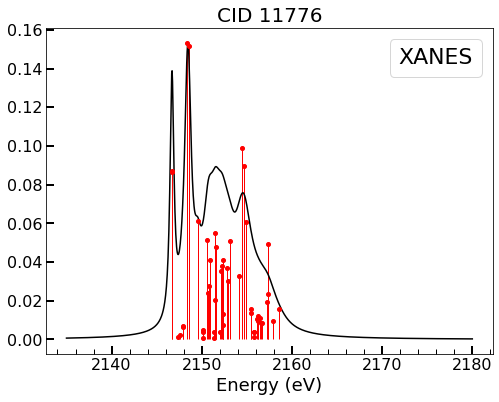

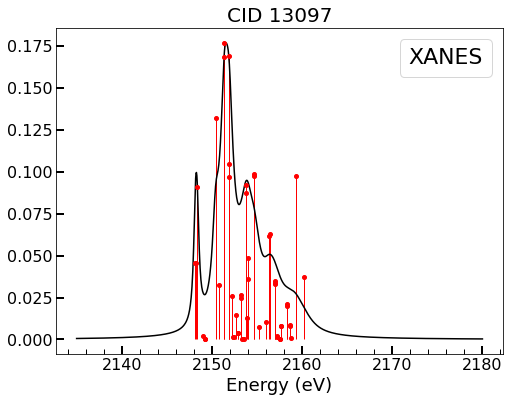

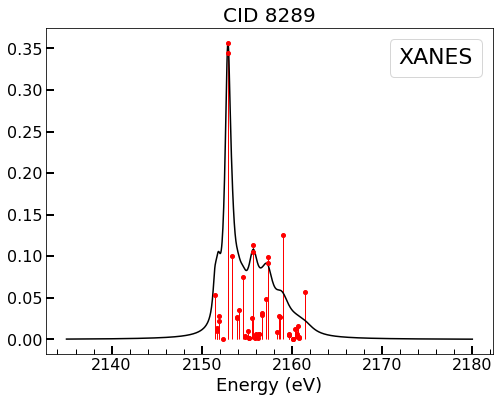

In [10]:
checkcids = [11776, 13097, 8289]

for cid in checkcids:    
    c = compoundmap[cid]
    trans = c['XANES_Transitions']
    trans = esnip(trans, c['XANES_Normalized'], energy=XANES_energies, mode='xanes')
    plot_spectrum_and_trans([XANES_energies, c['XANES_Normalized']], trans, f'{cid}', label='XANES')

# Theory and Experiment Comparison

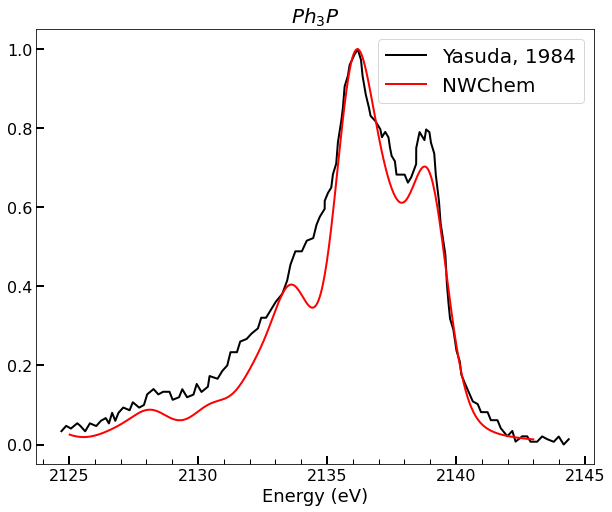

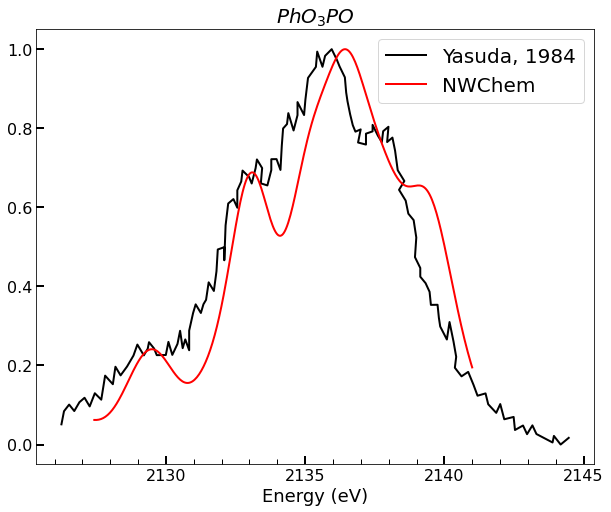

In [11]:
df1 = pd.read_csv('Ph3P.csv')
df2 = pd.read_csv('Ph3PO.csv')
df3 = pd.read_csv('PhO3PO.csv')

hc = 1.23984193e-6 #ev/m
d = 6.5327e-10 #m
def to_energy(two_theta):
    return hc/(d*np.sin(two_theta*(np.pi/180)/2))


def stack_plot(Spectrums, Labels, title=None,
               verbose=True, label=None, peaknorm=True):
    
    n = len(Spectrums)
    Colors=plt.cm.viridis(np.arange(n)/(n+1))
    if n == 2:
        Colors=['black', 'red']
    fig, ax = plt.subplots(figsize=(10,8))

    i = 0
    for spectrum in Spectrums:
        x, y = spectrum
        if peaknorm:
            y = y/np.max(y)
        ax.plot(x, y, '-', color=Colors[i], linewidth=2, label=Labels[i])
        i += 1

    if title is not None:
        plt.title(title, fontsize=20)
    plt.xlabel('Energy (eV)', fontsize=18)
    plt.tick_params(labelsize=16)

    if verbose:
        ax.xaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.tick_params(direction='in', width=1, length=5, which='minor')

    ax.tick_params(direction='in', width=2, length=8, which='major')

    plt.legend(fontsize=20)
    
    plt.show()

    
####################### spectrum 1
cid = checkcids[0]
x = to_energy(df1['2theta'].values)
y = df1['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 350, 800
x2 = XES_energies[emin:emax]
c = compoundmap[cid]
y2 = c['XES_Normalized'][emin:emax]
e_shift = x2[np.argmax(y2)] - x[np.argmax(y)]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$Ph_3P$")

####################### spectrum 2
cid = checkcids[2]
x = to_energy(df3['2theta'].values)
y = df3['I'].values
y = y - np.min(y)
y = y/np.max(y)
emin, emax = 410, 750
x2 = XES_energies[emin:emax]
c = compoundmap[cid]
y2 = c['XES_Normalized'][emin:emax]
stack_plot([[x, y],[x2-e_shift, y2]], ['Yasuda, 1984', 'NWChem'], title="$PhO_3PO$", verbose=True)

# ML and Data Science section

## All Spectra Together

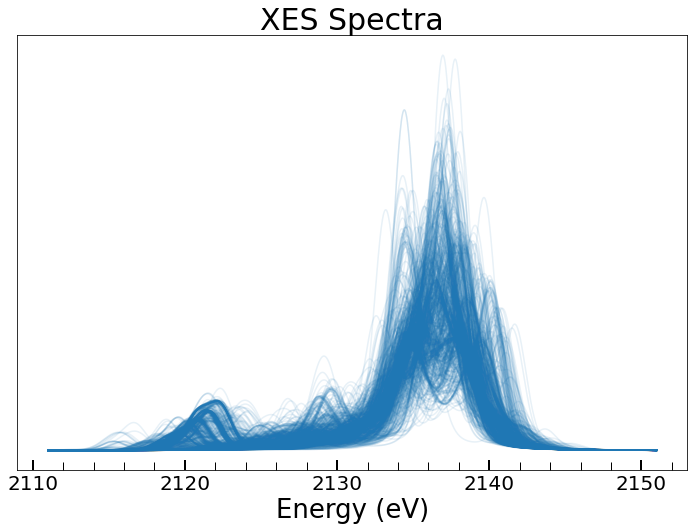

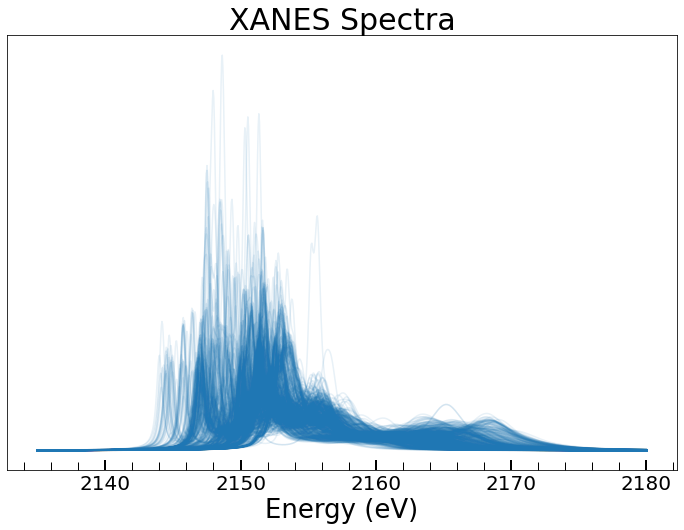

In [12]:
xesplt = plot_spaghetti(plt.subplots(figsize=(12,8)), X_data_classed, mode='XES', coloralpha=0.1);
xanesplt = plot_spaghetti(plt.subplots(figsize=(12,8)), X_data_classed, mode='XANES', coloralpha=0.1);

## Rainbow Spaghetti Plot: Color and Stack by Compound Class

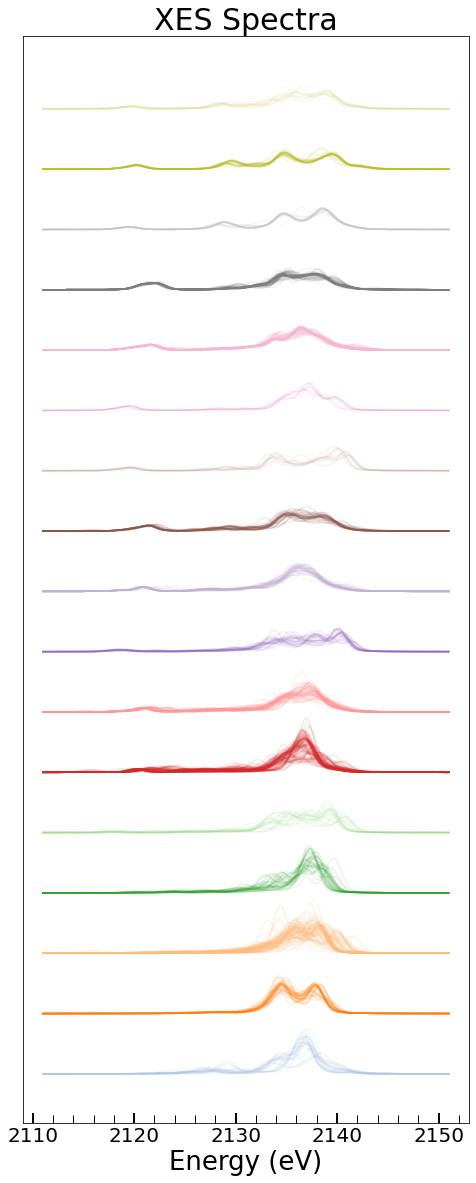

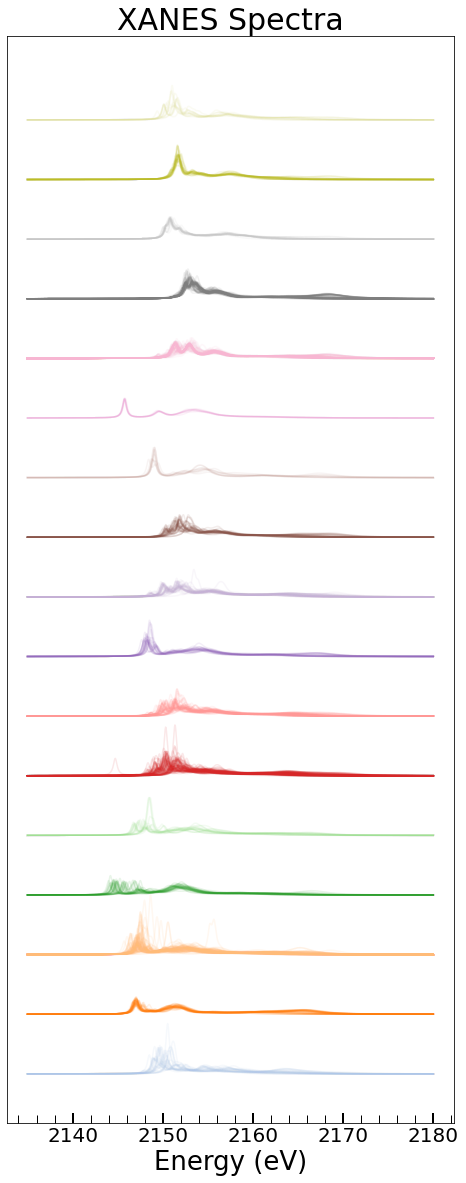

In [23]:
xesspagplt = plot_spaghetti(plt.subplots(figsize=(8,20)), X_data, colorcodemap=classcodemap, binmap=classcodemap,
               mode='XES', coloralpha=0.1, hiddencids=NoneCIDs);
xanesspagplt = plot_spaghetti(plt.subplots(figsize=(8,20)), X_data, colorcodemap=classcodemap, binmap=classcodemap,
               mode='XANES', coloralpha=0.1, hiddencids=NoneCIDs);

add_line_label(xesspagplt, X_data)
add_line_label(xanesspagplt, X_data)

# ML Reduced Space: PCA and t-SNE

In [14]:
warnings.filterwarnings("ignore")

XES = np.array([c['XES_Normalized'] for c in X_data_classed])
XANES = np.array([c['XANES_Normalized'] for c in X_data_classed])

# pca
pca1 = PCA(n_components=2)
XES_PCA = pca1.fit_transform(XES)

# pca
pca2 = PCA(n_components=2)
XANES_PCA = pca2.fit_transform(XANES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XES_TSNE = tsne.fit_transform(XES)

# tsne
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
XANES_TSNE = tsne.fit_transform(XANES)

In [15]:
# Make CID->point maps
XANES_pcamap = {compound['CID']:point for compound,point in zip(X_data_classed, XANES_PCA)}
XES_pcamap = {compound['CID']:point for compound,point in zip(X_data_classed, XES_PCA)}
XANES_tsnemap = {compound['CID']:point for compound,point in zip(X_data_classed, XANES_TSNE)}
XES_tsnemap = {compound['CID']:point for compound,point in zip(X_data_classed, XES_TSNE)}

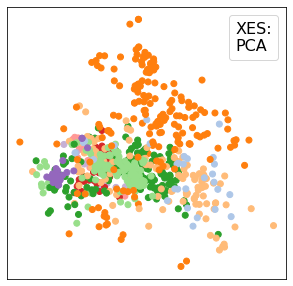

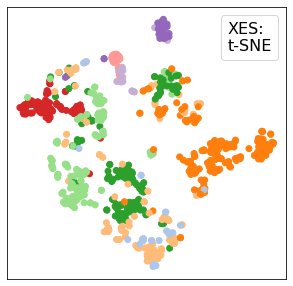

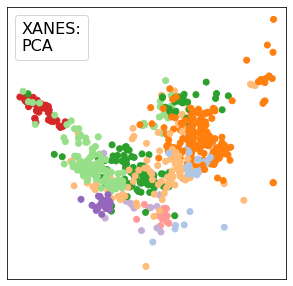

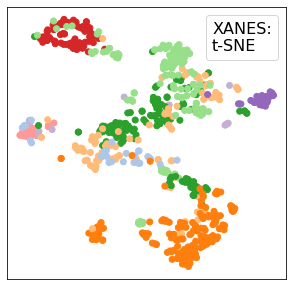

In [16]:
xespcaplt = plot_dim_red(plt.subplots(figsize=(5,5)), X_data_classed, XES_pcamap, colorcodemap=typecodemap, \
             mode='XES', method='PCA', hiddencids=NoneCIDs)
xestsneplt = plot_dim_red(plt.subplots(figsize=(5,5)), X_data_classed, XES_tsnemap, colorcodemap=typecodemap, \
             mode='XES', method='t-SNE', hiddencids=NoneCIDs)
xanespcaplt = plot_dim_red(plt.subplots(figsize=(5,5)), X_data_classed, XANES_pcamap, colorcodemap=typecodemap, \
             mode='XANES', method='PCA', hiddencids=NoneCIDs)
xanestsneplt = plot_dim_red(plt.subplots(figsize=(5,5)), X_data_classed, XANES_tsnemap, colorcodemap=typecodemap, \
             mode='XANES', method='t-SNE', hiddencids=NoneCIDs)

add_point_label(xespcaplt, X_data)
add_point_label(xestsneplt, X_data)
add_point_label(xanespcaplt, X_data)
add_point_label(xanestsneplt, X_data)

# Heirarchical Clustering

In [17]:
Z = linkage(XANES, method='ward')
# Z = linkage(XES, method='weighted', metric='cosine')

In [18]:
cmap = plt.cm.viridis(np.linspace(0, 1, 4))
hierarchy.set_link_color_palette([to_hex(rgb) for rgb in cmap])

In [19]:
p = 3
R = dendrogram(Z, truncate_mode='lastp', p=p, no_plot=True)
labels = np.arange(1,p + 1)
temp = {R["leaves"][ii]:(labels[ii], R["ivl"][ii]) for ii in range(len(R["leaves"]))}
def llf(xx):
    return "{}: {}".format(*temp[xx])

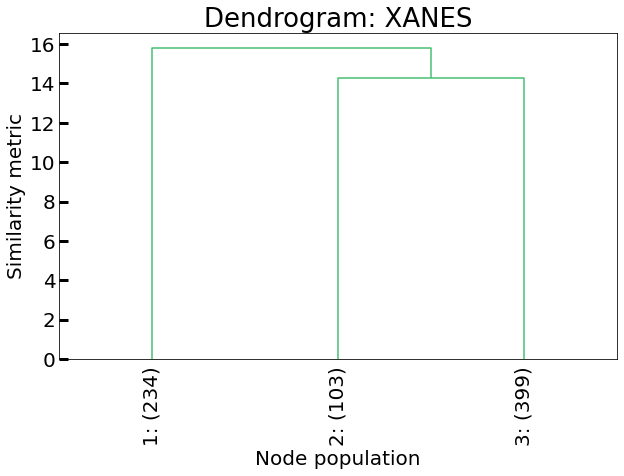

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.title('Dendrogram: XANES', fontsize=26)

# plot the top levels of the dendrogram
result = dendrogram(Z, truncate_mode='lastp', p=p,
                    above_threshold_color=plt.cm.viridis(0.7),
                    leaf_label_func=llf,
                    leaf_rotation=90)

ax.tick_params(axis='y',direction='in', width=3, length=9)
plt.ylabel("Similarity metric", fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Node population", fontsize=20)
plt.xticks(fontsize=20)

plt.show()

In [21]:
cluster_labels = fcluster(Z, p, criterion='maxclust')

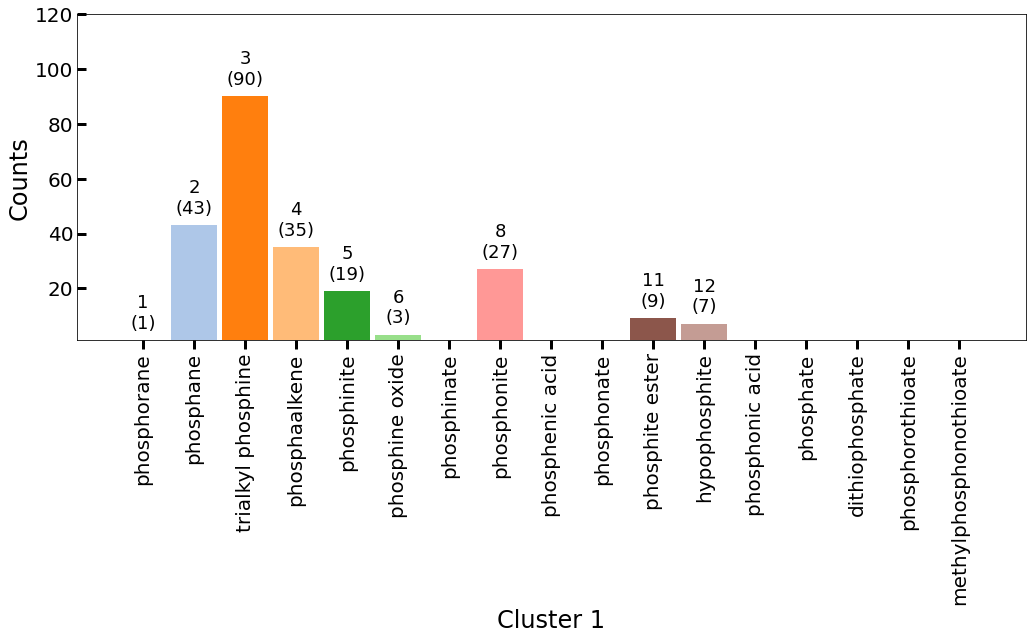

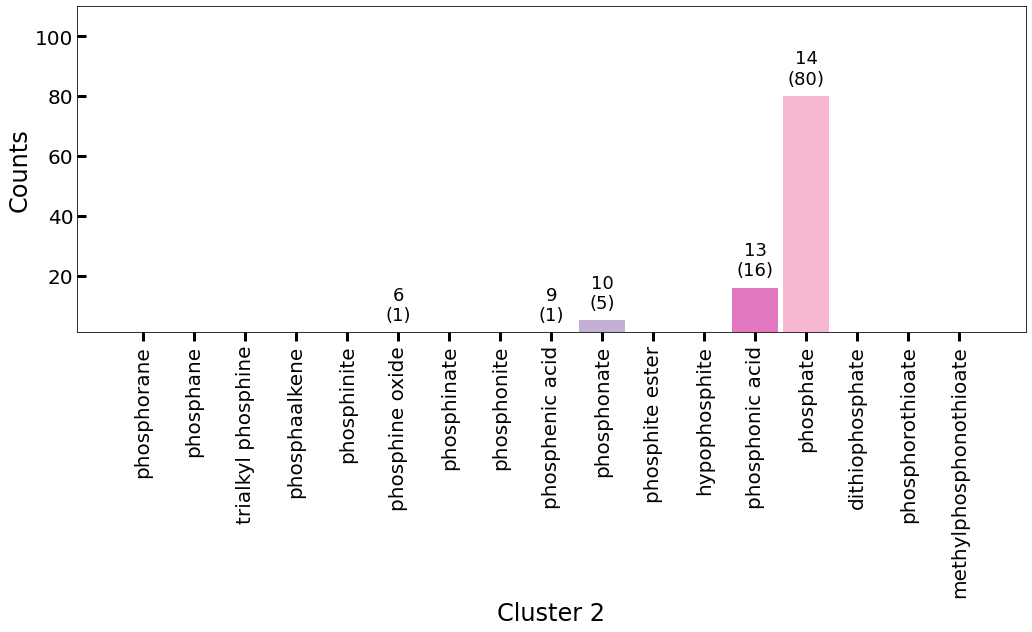

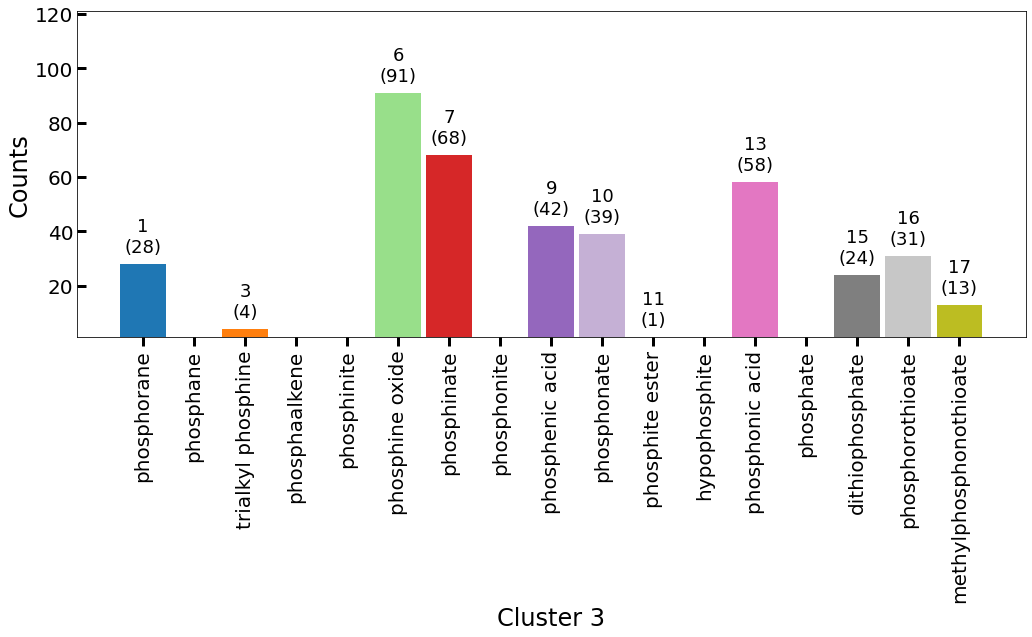

In [22]:
for i in range(1,p + 1):
    bool_arr = cluster_labels == i
    compoundclasses = [c['Class'] for c in X_data_classed]
    categorizer = list(compress(compoundclasses, bool_arr))

    classnames = list(CLASSCODES.keys())[:-1]
    bins = [np.sum(np.array(categorizer)==classname) for classname in classnames]
    
    hist(bins, [c.replace('_', ' ') for c in classnames], xlabel=f'Cluster {i}', verbose=True)